In [1]:
# import stuff
import os
import numpy as np
import matplotlib.pyplot as plt
from uncertainty_motion_prediction.dataloader import Dataloader
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator
from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)

In [2]:
dataset=Dataloader();
traj_dataset = dataset.load(0)

## As numpy array

In [3]:
trajlets = traj_dataset.get_trajlets(length=4.8, to_numpy=True)
trajlets[0, :, :]

array([[13.017548  ,  5.7825914 , -2.3244442 , -0.07660594, 53.6       ],
       [12.08777   ,  5.751949  , -1.5890517 , -0.06597106, 54.        ],
       [11.746306  ,  5.7298146 , -1.1407656 ,  0.10537256, 54.4       ],
       [11.175158  ,  5.8362471 , -1.6400209 ,  0.17923528, 54.8       ],
       [10.43429   ,  5.8732028 , -1.4061292 ,  0.41904965, 55.2       ],
       [10.050254  ,  6.1714868 , -1.0787423 ,  0.45518986, 55.6       ],
       [ 9.5712958 ,  6.2373547 , -1.207725  ,  0.11543663, 56.        ],
       [ 9.0840742 ,  6.2638361 , -1.2731811 ,  0.17084078, 56.4       ],
       [ 8.5527509 ,  6.3740273 , -1.2327335 ,  0.2715015 , 56.8       ],
       [ 8.0978874 ,  6.4810373 , -1.1467297 ,  0.21789191, 57.2       ],
       [ 7.6353672 ,  6.5483408 , -1.1634956 ,  0.16930578, 57.6       ],
       [ 7.1670909 ,  6.616482  , -1.1264929 ,  0.11639996, 58.        ]])

# Hidden Markov Model with trajectory sub-segment latent states

This method works by modelling a pedestrian trajectory as being composed of multiple common segment primitives. Developing the HMM model consists of 2 parts:
* Extracting common trajectory sub-segments from data. These sub-segments or segment primitives will be the states of the HMM.
* Learn the transition matrix of the HMM. To predict the pedestrian's trajectory, we need the ability to predict the next state or segment primitive the pedestrian will transit to after the current segment the pedestrian is executing.

### Sanity checks

We perform some sanity checks on artificial data first to validate the HMM algorithm. Generate the artificial trajectories from a set of 5 different trajectory types

In [6]:
seg_type1 = [[0, 0, 1, 0], [1, 0, 5, 0], [6, 0, 5, 0]]
seg_type2 = [[0, 0, 1, 0], [1, 0, 1, 0], [2, 0, 1, 0]]
seg_type3 = [[0, 0, 1, 0], [1, 0, 1, 1], [2, 1, 1, 1]]
seg_type4 = [[0, 0, 1, 0], [1, 0, 1, -1], [2, -1, 1, -1]]
seg_type5 = [[0, 0, 1, 0], [1, 0, -2, 0], [-1, 0, -2, 0]]

seg_types = np.array([seg_type1, seg_type2, seg_type3, seg_type4, seg_type5])
test_trajs = []

for seg_type in seg_types:
    for i in range(3):
        angle = np.random.uniform(-2*np.pi, 2*np.pi)
        scale = np.random.uniform(0.5, 1.5)
        trans = np.array([[np.random.uniform(-10, 10), np.random.uniform(-10, 10)]]).T

        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])
        S = np.array([[scale, 0], 
                      [0, scale]])

        seg = np.dot(S, np.dot(R, seg_type[:, 0:2].T))
        seg = seg + trans
        seg_vels = np.dot(S, np.dot(R, seg_type[:, 2:].T))
        sample = np.hstack((seg.T, seg_vels.T))
        test_trajs.append(sample)
        
print(test_trajs)
print(np.array(test_trajs).shape)

[array([[-6.24230297,  9.63035033,  0.54669212,  0.98014763],
       [-5.69561084, 10.61049796,  2.73346061,  4.90073814],
       [-2.96215023, 15.5112361 ,  2.73346061,  4.90073814]]), array([[-1.31908054,  9.66887069, -0.58665844,  0.94914262],
       [-1.90573898, 10.61801331, -2.93329219,  4.74571311],
       [-4.83903117, 15.36372642, -2.93329219,  4.74571311]]), array([[  7.76610152,  -7.29750402,  -0.27043836,  -0.50404854],
       [  7.49566316,  -7.80155256,  -1.3521918 ,  -2.52024272],
       [  6.14347136, -10.32179529,  -1.3521918 ,  -2.52024272]]), array([[-5.44444854,  1.73758366,  0.68129622,  0.87650704],
       [-4.76315232,  2.6140907 ,  0.68129622,  0.87650704],
       [-4.08185611,  3.49059775,  0.68129622,  0.87650704]]), array([[-7.17275775, -2.45412154, -0.34029417,  1.40773642],
       [-7.51305193, -1.04638512, -0.34029417,  1.40773642],
       [-7.8533461 ,  0.36135129, -0.34029417,  1.40773642]]), array([[ 8.98664482, -4.54980947, -0.02669731, -0.70103967],
 

Test the performance of the clustering step. The code implements 2 different ways to do this: 1) X-means which automatically selects the optimal number of clusters using Bayesian Information Criterion, 2) iterative K-means over a range of possible numbers of clusters, with the user left to select the optimal number of clusters manually from the extracted distance-to-centroid and silhouette methods.

We test (2), since the X-means approach with BIC seems prone to over-clustering.

Text(0.5, 1.0, 'Silhouette scores')

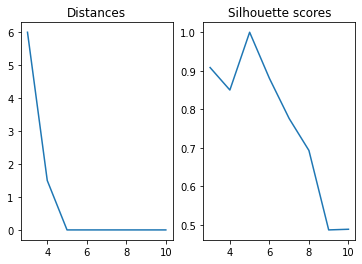

In [7]:
extractor = HMMLatentSegmentsExtractor(segment_len=3)

dists, silhouettes, clusters, centres = extractor.learn_latent_segments_manual_kmeans(np.array(test_trajs))
cluster_range = range(extractor._n_min_centres, extractor._n_max_centres + 1)

fig, axs = plt.subplots(1, 2)
axs[0].plot(cluster_range, dists)
axs[1].plot(cluster_range, silhouettes)
axs[0].set_title('Distances')
axs[1].set_title('Silhouette scores')

In [9]:
clustering_tmp = KMeansOutcome(3, centres[2])
clustering_tmp.save_to_file("./tmp_clustering.pickle")
clustering = KMeansOutcome.load_from_file("./tmp_clustering.pickle")
print(clustering.N)
clustering.classify_batch(test_trajs)

5


[1, 1, 1, 4, 4, 4, 3, 3, 3, 0, 0, 0, 2, 2, 2]

In [10]:
centres[2]

[[0.0, 1.0, 2.0, 0.0, 2.894755193667473e-16, -1.0],
 [0.0,
  1.0,
  6.000000000000003,
  0.0,
  -2.7491191706942805e-16,
  -1.4802973661668753e-16],
 [0.0,
  1.0000000000000002,
  -1.0000000000000002,
  0.0,
  -2.504513916788477e-16,
  2.590520390792032e-16],
 [0.0, 0.9999999999999999, 2.0, 0.0, 2.893978556126896e-17, 1.0],
 [0.0, 1.0, 2.0, 0.0, 4.390427525217475e-16, -4.440892098500626e-16]]

### Learn segments from data

In [3]:
segment_length = 4
trajlets_for_segments_learning = traj_dataset.get_trajlets(length=segment_length*0.4, overlap=1, to_numpy=True)
print(trajlets_for_segments_learning.shape)

(3478, 4, 5)


In [4]:
extractor = HMMLatentSegmentsExtractor(
    segment_len=segment_length, n_min_centres=10, n_max_centres=100, estimate_velocity=True
)
dists, silhouettes, clusters, centres = extractor.learn_latent_segments_manual_kmeans(
    trajlets_for_segments_learning[:, :, 0:4]
)
cluster_range = range(extractor._n_min_centres, extractor._n_max_centres + 1)

Text(0.5, 1.0, 'Silhouette scores')

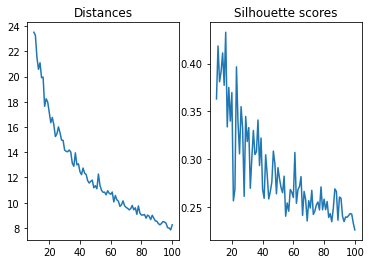

In [5]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(cluster_range, dists)
axs[1].plot(cluster_range, silhouettes)
axs[0].set_title('Distances')
axs[1].set_title('Silhouette scores')

In [6]:
center_idx = 40
print(dists[center_idx])
center = np.array(centres[center_idx])
clustering = KMeansOutcome(segment_length, center)
clustering.save_to_file("./hmm_segment_clustering.pickle")
print(clustering.N)

11.35030489005174
50


In [7]:
patterns = center.reshape([-1, 2, segment_length])
print(patterns.shape)

(50, 2, 4)


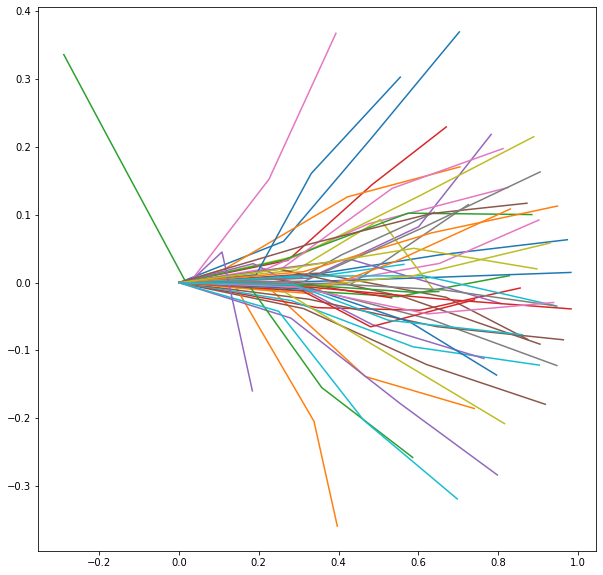

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for p in patterns[:, :, :]:
    axs.plot(p[0, :], p[1, :])

### Learn HMM model

In [3]:
segment_length = 4
num_segment = 4
clustering = KMeansOutcome.load_from_file("./hmm_segment_clustering.pickle")
assert clustering.segment_length == segment_length
trajlets_for_hmm_learning = traj_dataset.get_trajlets(
    length=num_segment * segment_length*0.4, overlap=4, to_numpy=True
)
print(trajlets_for_hmm_learning.shape)

(666, 16, 5)


In [4]:
# print(trajlets_for_hmm_learning[0, 0:12, 0:4])
# print(trajlets_for_hmm_learning[0, 0:12, 0:4].reshape([3, 4, 4]))

In [5]:
observations = []
for t in trajlets_for_hmm_learning:
    obs = clustering.classify_batch(t[0:12, 0:4].reshape([3, 4, 4]))
    observations.append(obs)

In [6]:
observations

[[13, 13, 18],
 [33, 0, 0],
 [27, 21, 21],
 [3, 48, 39],
 [8, 20, 20],
 [33, 36, 16],
 [20, 36, 39],
 [17, 0, 22],
 [17, 18, 0],
 [11, 0, 20],
 [17, 0, 0],
 [35, 0, 20],
 [33, 27, 34],
 [20, 13, 17],
 [36, 27, 29],
 [18, 27, 35],
 [27, 18, 0],
 [3, 13, 47],
 [48, 15, 33],
 [36, 39, 17],
 [17, 0, 34],
 [44, 0, 33],
 [17, 20, 22],
 [23, 33, 33],
 [17, 35, 20],
 [0, 27, 20],
 [16, 16, 44],
 [8, 27, 20],
 [4, 33, 20],
 [43, 15, 17],
 [44, 33, 17],
 [45, 39, 13],
 [34, 35, 11],
 [45, 39, 16],
 [41, 0, 8],
 [31, 18, 36],
 [15, 8, 18],
 [8, 35, 17],
 [20, 34, 17],
 [38, 0, 0],
 [22, 17, 35],
 [7, 22, 20],
 [41, 17, 17],
 [16, 29, 18],
 [18, 17, 17],
 [33, 39, 33],
 [16, 29, 18],
 [27, 29, 27],
 [34, 38, 17],
 [0, 20, 33],
 [11, 20, 20],
 [17, 0, 29],
 [17, 17, 20],
 [43, 34, 22],
 [0, 27, 11],
 [3, 39, 33],
 [0, 20, 0],
 [33, 20, 38],
 [37, 8, 39],
 [0, 38, 0],
 [0, 22, 17],
 [44, 20, 17],
 [18, 33, 17],
 [27, 0, 20],
 [0, 20, 27],
 [18, 33, 17],
 [18, 20, 0],
 [20, 11, 22],
 [27, 18, 35],
 [

In [55]:
state_dim = 80
hmm = HMMMultinomialFirstOrder(state_dim, clustering.N, verbose=True, max_iters=3)
try:
    hmm.load_from_file("./hmm_model_param.pickle")
except Exception as e:
    print("Fail to load parameters. Maybe they do not exist yet.")
    print(e)
hmm.estimate_parameters(np.array(observations))
hmm.save_to_file("./hmm_model_param.pickle")

Estimating HMM model parameters...
Iter 1, log-likelihood loss: -7.30159496307225, delta: inf
Iter 2, log-likelihood loss: -7.3009666224887, delta: 0.000628340583549658
Iter 3, log-likelihood loss: -7.3002250496075485, delta: 0.0007415728811519529
Iter 4, log-likelihood loss: -7.29913620793379, delta: 0.001088841673758445
Iter 5, log-likelihood loss: -7.29799877052635, delta: 0.0011374374074399896
Iter 6, log-likelihood loss: -7.2972131751713585, delta: 0.000785595354991564
Iter 7, log-likelihood loss: -7.296523839108213, delta: 0.0006893360631456957
Iter 8, log-likelihood loss: -7.29573100305438, delta: 0.0007928360538329571
Iter 9, log-likelihood loss: -7.294909458927644, delta: 0.0008215441267358514
Iter 10, log-likelihood loss: -7.294307154994782, delta: 0.0006023039328617585


### Predict

In [3]:
clustering = KMeansOutcome.load_from_file("./hmm_segment_clustering.pickle")
state_dim = 80
hmm = HMMMultinomialFirstOrder(state_dim, clustering.N, verbose=True, max_iters=3)
hmm.load_from_file("./hmm_model_param.pickle")
predictor = HMMLatentSegmentsPredictor(hmm, clustering)

In [4]:
segment_length = 4
num_segment = 4
num_history_segment = 3
trajlets_for_testing = traj_dataset.get_trajlets(
    length=segment_length * num_segment * 0.4,
    overlap=1,
    to_numpy=True
)
print(trajlets_for_testing.shape)

(361, 16, 5)


In [5]:
traj = trajlets_for_testing[30]
print(traj[:, 0:2])
predictor.predict(traj[0:4 * num_history_segment, :])

[[11.428242    4.4082305 ]
 [10.640157    4.1917857 ]
 [ 9.8310942   3.9295902 ]
 [ 9.0076642   3.7838973 ]
 [ 8.2064501   3.6339105 ]
 [ 7.3864681   3.4804103 ]
 [ 6.5936127   3.3651828 ]
 [ 5.8229828   3.1608805 ]
 [ 5.0893833   3.0820297 ]
 [ 4.3878826   3.0011859 ]
 [ 3.4786547   2.8758434 ]
 [ 2.6610118   2.9712992 ]
 [ 1.8630656   2.8870934 ]
 [ 1.0993477   2.8008228 ]
 [ 0.36502511  2.6201061 ]
 [-0.34984213  2.2020414 ]]


(array([[1.80526049, 2.7403309 ],
        [1.0777209 , 2.16727416],
        [1.84214393, 3.05626232],
        [1.79672472, 3.00844622]]),
 array([[[0.        , 0.39922575],
         [0.79711446, 1.19314929],
         [0.        , 0.01283284],
         [0.04806654, 0.07692479]]]))

### Evaluation

In [59]:
evaluator = DistanceErrorEvaluator(N_future=4)

In [60]:
evaluator.evaluate(predictor, trajlets_for_testing)

{'fde': array([1.12647366, 1.56559456, 1.12419352, 1.68182273, 1.90797477,
        1.85434055, 1.42538416, 1.90248838, 1.25910985, 1.64259815,
        1.4723813 , 1.39775997, 1.44010504, 1.43566512, 1.37889133,
        1.35825354, 1.62854819, 1.80586956, 1.7677294 , 1.59168479,
        1.75701052, 1.83692199, 1.78757825, 1.6635889 , 1.21002921,
        1.57394111, 1.87682415, 1.54852154, 1.42261681, 1.98219639,
        2.29304121, 2.28668087, 1.79684106, 1.71411956, 1.55215284,
        1.56965051, 1.64474807, 1.89863758, 1.94827248, 1.82220131,
        2.31455833, 1.77720922, 2.02031981, 1.91592567, 1.9073062 ,
        1.94118928, 2.10959644, 1.4378855 , 1.26680727, 2.02383115,
        1.58750564, 1.77008698, 1.89228619, 1.71468993, 2.48559193,
        1.90186694, 1.43762684, 1.51965443, 2.13424541, 2.13328398,
        2.01231578, 1.68813809, 1.62536807, 1.57338669, 2.26481697,
        2.12748479, 1.81553315, 1.93320058, 2.31517159, 1.91178129,
        1.62020213, 1.52819563, 1.6117282